In [0]:
!mkdir data

In [3]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

--2018-03-07 11:37:17--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar         1%[                    ] 127.49M  3.06MB/s    eta 36m 1s 

imdb_crop.tar        99%[==================> ]   6.53G  4.43MB/s    eta 1s     

imdb_crop.tar       100%[===================>]   6.53G  4.43MB/s    in 31m 54s 

2018-03-07 12:09:12 (3.49 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



In [0]:
!mv imdb_crop.tar data/

In [0]:
!tar xf data/imdb_crop.tar

In [0]:
!mv imdb_crop/ data/

In [0]:
from scipy.io import loadmat
from datetime import datetime
import os


def calc_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    # assume the photo was taken in the middle of the year
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1


def get_meta(mat_path, db):
    meta = loadmat(mat_path)
    full_path = meta[db][0, 0]["full_path"][0]
    dob = meta[db][0, 0]["dob"][0]  # Matlab serial date number
    gender = meta[db][0, 0]["gender"][0]
    photo_taken = meta[db][0, 0]["photo_taken"][0]  # year
    face_score = meta[db][0, 0]["face_score"][0]
    second_face_score = meta[db][0, 0]["second_face_score"][0]
    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

    return full_path, dob, gender, photo_taken, face_score, second_face_score, age


def load_data(mat_path):
    d = loadmat(mat_path)

    return d["image"], d["gender"][0], d["age"][0], d["db"][0], d["img_size"][0, 0], d["min_score"][0, 0]


def mk_dir(dir):
    try:
        os.mkdir( dir )
    except OSError:
        pass

In [0]:
# https://keras.io/
!pip install -q keras

In [0]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y
      
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

import logging
import sys
import numpy as np
from keras.models import Model
from keras.layers import Input, Activation, add, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)


class WideResNet:
    def __init__(self, image_size, depth=16, k=8):
        self._depth = depth
        self._k = k
        self._dropout_probability = 0
        self._weight_decay = 0.0005
        self._use_bias = False
        self._weight_init = "he_normal"

        if K.image_dim_ordering() == "th":
            logging.debug("image_dim_ordering = 'th'")
            self._channel_axis = 1
            self._input_shape = (3, image_size, image_size)
        else:
            logging.debug("image_dim_ordering = 'tf'")
            self._channel_axis = -1
            self._input_shape = (image_size, image_size, 3)

    # Wide residual network http://arxiv.org/abs/1605.07146
    def _wide_basic(self, n_input_plane, n_output_plane, stride):
        def f(net):
            # format of conv_params:
            #               [ [kernel_size=("kernel width", "kernel height"),
            #               strides="(stride_vertical,stride_horizontal)",
            #               padding="same" or "valid"] ]
            # B(3,3): orignal <<basic>> block
            conv_params = [[3, 3, stride, "same"],
                           [3, 3, (1, 1), "same"]]

            n_bottleneck_plane = n_output_plane

            # Residual block
            for i, v in enumerate(conv_params):
                if i == 0:
                    if n_input_plane != n_output_plane:
                        net = BatchNormalization(axis=self._channel_axis)(net)
                        net = Activation("relu")(net)
                        convs = net
                    else:
                        convs = BatchNormalization(axis=self._channel_axis)(net)
                        convs = Activation("relu")(convs)

                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)
                else:
                    convs = BatchNormalization(axis=self._channel_axis)(convs)
                    convs = Activation("relu")(convs)
                    if self._dropout_probability > 0:
                        convs = Dropout(self._dropout_probability)(convs)
                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)

            # Shortcut Connection: identity function or 1x1 convolutional
            #  (depends on difference between input & output shape - this
            #   corresponds to whether we are using the first block in each
            #   group; see _layer() ).
            if n_input_plane != n_output_plane:
                shortcut = Conv2D(n_output_plane, kernel_size=(1, 1),
                                         strides=stride,
                                         padding="same",
                                         kernel_initializer=self._weight_init,
                                         kernel_regularizer=l2(self._weight_decay),
                                         use_bias=self._use_bias)(net)
            else:
                shortcut = net

            return add([convs, shortcut])

        return f


    # "Stacking Residual Units on the same stage"
    def _layer(self, block, n_input_plane, n_output_plane, count, stride):
        def f(net):
            net = block(n_input_plane, n_output_plane, stride)(net)
            for i in range(2, int(count + 1)):
                net = block(n_output_plane, n_output_plane, stride=(1, 1))(net)
            return net

        return f

#    def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")

        assert ((self._depth - 4) % 6 == 0)
        n = (self._depth - 4) / 6

        inputs = Input(shape=self._input_shape)

        n_stages = [16, 16 * self._k, 32 * self._k, 64 * self._k]

        conv1 = Conv2D(filters=n_stages[0], kernel_size=(3, 3),
                              strides=(1, 1),
                              padding="same",
                              kernel_initializer=self._weight_init,
                              kernel_regularizer=l2(self._weight_decay),
                              use_bias=self._use_bias)(inputs)  # "One conv at the beginning (spatial size: 32x32)"

        # Add wide residual blocks
        block_fn = self._wide_basic
        conv2 = self._layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1, 1))(conv1)
        conv3 = self._layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2, 2))(conv2)
        conv4 = self._layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2, 2))(conv3)
        batch_norm = BatchNormalization(axis=self._channel_axis)(conv4)
        relu = Activation("relu")(batch_norm)

        # Classifier block
        pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
        flatten = Flatten()(pool)
        predictions_g = Dense(units=2, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)
        predictions_a = Dense(units=101, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)

        model = Model(inputs=inputs, outputs=[predictions_g, predictions_a])

        return model

class Schedule:
    def __init__(self, nb_epochs):
        self.epochs = nb_epochs

    def __call__(self, epoch_idx):
        if epoch_idx < self.epochs * 0.25:
            return 0.1
        elif epoch_idx < self.epochs * 0.5:
            return 0.02
        elif epoch_idx < self.epochs * 0.75:
            return 0.004
        return 0.0008


In [12]:
!pip install tqdm

    100% |████████████████████████████████| 61kB 2.9MB/s 


In [14]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Selecting previously unselected package libxext6:amd64.
(Reading database ... 16669 files and directories currently installed.)
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.

In [15]:
import numpy as np
import cv2
import scipy.io
import argparse
from tqdm import tqdm
#args = get_args()
output_path = "imdb_db.mat"
db = "imdb"
img_size = 32
min_score = 1.0

root_path = "data/{}_crop/".format(db)
mat_path = root_path + "{}.mat".format(db)
full_path, dob, gender, photo_taken, face_score, second_face_score, age = get_meta(mat_path, db)

out_genders = []
out_ages = []
out_imgs = []

for i in tqdm(range(len(face_score))):
    if face_score[i] < min_score:
        continue

    if (~np.isnan(second_face_score[i])) and second_face_score[i] > 0.0:
        continue

    if ~(0 <= age[i] <= 100):
        continue

    if np.isnan(gender[i]):
        continue

    out_genders.append(int(gender[i]))
    out_ages.append(age[i])
    img = cv2.imread(root_path + str(full_path[i][0]))
    out_imgs.append(cv2.resize(img, (img_size, img_size)))

output = {"image": np.array(out_imgs), "gender": np.array(out_genders), "age": np.array(out_ages),
          "db": db, "img_size": img_size, "min_score": min_score}
scipy.io.savemat(output_path, output)


100%|██████████| 460723/460723 [05:18<00:00, 1445.10it/s]


In [16]:
import pandas as pd
import logging
import argparse
import os
import numpy as np
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


#args = get_args()
input_path = "imdb_db.mat"
batch_size = 32
nb_epochs = 2
depth = 16
k = 8
validation_split = 0.1
use_augmentation = False
logging.debug("Loading data...")
image, gender, age, _, image_size, _ = load_data(input_path)
X_data = image
y_data_g = np_utils.to_categorical(gender, 2)
y_data_a = np_utils.to_categorical(age, 101)

model = WideResNet(image_size, depth=depth, k=k)()
sgd = SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss=["categorical_crossentropy", "categorical_crossentropy"],
              metrics=['accuracy'])

logging.debug("Model summary...")
model.count_params()
model.summary()

logging.debug("Saving model...")
mk_dir("models")
with open(os.path.join("models", "WRN_{}_{}.json".format(depth, k)), "w") as f:
    f.write(model.to_json())

mk_dir("checkpoints")
callbacks = [LearningRateScheduler(schedule=Schedule(nb_epochs)),
             ModelCheckpoint("checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode="auto")
            ]
logging.debug("Running training...")

data_num = len(X_data)
indexes = np.arange(data_num)
np.random.shuffle(indexes)
X_data = X_data[indexes]
y_data_g = y_data_g[indexes]
y_data_a = y_data_a[indexes]
train_num = int(data_num * (1 - validation_split))
X_train = X_data[:train_num]
X_test = X_data[train_num:]
y_train_g = y_data_g[:train_num]
y_test_g = y_data_g[train_num:]
y_train_a = y_data_a[:train_num]
y_test_a = y_data_a[train_num:]

if use_augmentation:
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=0, v_h=255))
    training_generator = MixupGenerator(X_train, [y_train_g, y_train_a], batch_size=batch_size, alpha=0.2,
                                        datagen=datagen)()
    hist = model.fit_generator(generator=training_generator,
                               steps_per_epoch=train_num // batch_size,
                               validation_data=(X_test, [y_test_g, y_test_a]),
                               epochs=nb_epochs, verbose=1,
                               callbacks=callbacks)
else:
    hist = model.fit(X_train, [y_train_g, y_train_a], batch_size=batch_size, epochs=nb_epochs, callbacks=callbacks,
                     validation_data=(X_test, [y_test_g, y_test_a]))

logging.debug("Saving weights...")
model.save_weights(os.path.join("models", "WRN_{}_{}.h5".format(depth, k)), overwrite=True)
#pd.DataFrame(hist.history).to_hdf(os.path.join("models", "history_{}_{}.h5".format(depth, k)), "history")


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

 19360/154666 [==>...........................] - ETA: 14:01 - loss: 26.6971 - dense_1_loss: 8.9052 - dense_2_loss: 15.6084 - dense_1_acc: 0.4467 - dense_2_acc: 0.0304

 38592/154666 [======>.......................] - ETA: 11:46 - loss: 25.8673 - dense_1_loss: 8.8223 - dense_2_loss: 15.6268 - dense_1_acc: 0.4522 - dense_2_acc: 0.0299

 57760/154666 [==========>...................] - ETA: 9:45 - loss: 25.4477 - dense_1_loss: 8.8260 - dense_2_loss: 15.6102 - dense_1_acc: 0.4521 - dense_2_acc: 0.0311

 77120/154666 [=============>................] - ETA: 7:46 - loss: 23.9383 - dense_1_loss: 7.6680 - dense_2_loss: 14.0211 - dense_1_acc: 0.4628 - dense_2_acc: 0.0317

 96480/154666 [=================>............] - ETA: 5:49 - loss: 21.0550 - dense_1_loss: 6.2930 - dense_2_loss: 12.0546 - dense_1_acc: 0.4728 - dense_2_acc: 0.0325

115840/154666 [=====================>........] - ETA: 3:52 - loss: 18.5512 - dense_1_loss: 5.3581 - dense_2_loss: 10.7059 - dense_1_acc: 0.4820 - dense_2_acc: 0.0325

135232/154666 [=========================>....] - ETA: 1:56 - loss: 16.6197 - dense_1_loss: 4.6851 - dense_2_loss: 9.7407 - dense_1_acc: 0.4978 - dense_2_acc: 0.0330

154666/154666 [==============================] - 960s 6ms/step - loss: 15.1276 - dense_1_loss: 4.1707 - dense_2_loss: 9.0163 - dense_1_acc: 0.5233 - dense_2_acc: 0.0331 - val_loss: 4.7494 - val_dense_1_loss: 0.6506 - val_dense_2_loss: 3.9716 - val_dense_1_acc: 0.6263 - val_dense_2_acc: 0.0329



Epoch 00001: val_loss improved from inf to 4.74939, saving model to checkpoints/weights.01-4.75.hdf5
Epoch 2/2
 11552/154666 [=>............................] - ETA: 14:11 - loss: 4.6422 - dense_1_loss: 0.5578 - dense_2_loss: 3.9588 - dense_1_acc: 0.7246 - dense_2_acc: 0.0385

 30944/154666 [=====>........................] - ETA: 12:14 - loss: 4.6079 - dense_1_loss: 0.5417 - dense_2_loss: 3.9434 - dense_1_acc: 0.7337 - dense_2_acc: 0.0379

 50400/154666 [========>.....................] - ETA: 10:19 - loss: 4.5856 - dense_1_loss: 0.5347 - dense_2_loss: 3.9309 - dense_1_acc: 0.7381 - dense_2_acc: 0.0379

 69952/154666 [============>.................] - ETA: 8:22 - loss: 4.5734 - dense_1_loss: 0.5309 - dense_2_loss: 3.9251 - dense_1_acc: 0.7410 - dense_2_acc: 0.0374

 89536/154666 [================>.............] - ETA: 6:26 - loss: 4.5657 - dense_1_loss: 0.5263 - dense_2_loss: 3.9246 - dense_1_acc: 0.7438 - dense_2_acc: 0.0370

109120/154666 [====================>.........] - ETA: 4:30 - loss: 4.5568 - dense_1_loss: 0.5226 - dense_2_loss: 3.9218 - dense_1_acc: 0.7461 - dense_2_acc: 0.0369

128704/154666 [=======================>......] - ETA: 2:34 - loss: 4.5498 - dense_1_loss: 0.5188 - dense_2_loss: 3.9208 - dense_1_acc: 0.7485 - dense_2_acc: 0.0366

148320/154666 [===========================>..] - ETA: 37s - loss: 4.5410 - dense_1_loss: 0.5150 - dense_2_loss: 3.9179 - dense_1_acc: 0.7506 - dense_2_acc: 0.0366

154666/154666 [==============================] - 952s 6ms/step - loss: 4.5385 - dense_1_loss: 0.5138 - dense_2_loss: 3.9172 - dense_1_acc: 0.7511 - dense_2_acc: 0.0367 - val_loss: 4.4739 - val_dense_1_loss: 0.4754 - val_dense_2_loss: 3.9072 - val_dense_1_acc: 0.7750 - val_dense_2_acc: 0.0372

Epoch 00002: val_loss improved from 4.74939 to 4.47390, saving model to checkpoints/weights.02-4.47.hdf5


ImportError: ignored

In [0]:

import logging
import sys
import numpy as np
from keras.models import Model
from keras.layers import Input, Activation, add, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)


class WideResNet:
    def __init__(self, image_size, depth=16, k=8):
        self._depth = depth
        self._k = k
        self._dropout_probability = 0
        self._weight_decay = 0.0005
        self._use_bias = False
        self._weight_init = "he_normal"

        if K.image_dim_ordering() == "th":
            logging.debug("image_dim_ordering = 'th'")
            self._channel_axis = 1
            self._input_shape = (3, image_size, image_size)
        else:
            logging.debug("image_dim_ordering = 'tf'")
            self._channel_axis = -1
            self._input_shape = (image_size, image_size, 3)

    # Wide residual network http://arxiv.org/abs/1605.07146
    def _wide_basic(self, n_input_plane, n_output_plane, stride):
        def f(net):
            # format of conv_params:
            #               [ [kernel_size=("kernel width", "kernel height"),
            #               strides="(stride_vertical,stride_horizontal)",
            #               padding="same" or "valid"] ]
            # B(3,3): orignal <<basic>> block
            conv_params = [[3, 3, stride, "same"],
                           [3, 3, (1, 1), "same"]]

            n_bottleneck_plane = n_output_plane

            # Residual block
            for i, v in enumerate(conv_params):
                if i == 0:
                    if n_input_plane != n_output_plane:
                        net = BatchNormalization(axis=self._channel_axis)(net)
                        net = Activation("relu")(net)
                        convs = net
                    else:
                        convs = BatchNormalization(axis=self._channel_axis)(net)
                        convs = Activation("relu")(convs)

                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)
                else:
                    convs = BatchNormalization(axis=self._channel_axis)(convs)
                    convs = Activation("relu")(convs)
                    if self._dropout_probability > 0:
                        convs = Dropout(self._dropout_probability)(convs)
                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)

            # Shortcut Connection: identity function or 1x1 convolutional
            #  (depends on difference between input & output shape - this
            #   corresponds to whether we are using the first block in each
            #   group; see _layer() ).
            if n_input_plane != n_output_plane:
                shortcut = Conv2D(n_output_plane, kernel_size=(1, 1),
                                         strides=stride,
                                         padding="same",
                                         kernel_initializer=self._weight_init,
                                         kernel_regularizer=l2(self._weight_decay),
                                         use_bias=self._use_bias)(net)
            else:
                shortcut = net

            return add([convs, shortcut])

        return f


    # "Stacking Residual Units on the same stage"
    def _layer(self, block, n_input_plane, n_output_plane, count, stride):
        def f(net):
            net = block(n_input_plane, n_output_plane, stride)(net)
            for i in range(2, int(count + 1)):
                net = block(n_output_plane, n_output_plane, stride=(1, 1))(net)
            return net

        return f

#    def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")

        assert ((self._depth - 4) % 6 == 0)
        n = (self._depth - 4) / 6

        inputs = Input(shape=self._input_shape)

        n_stages = [16, 16 * self._k, 32 * self._k, 64 * self._k]

        conv1 = Conv2D(filters=n_stages[0], kernel_size=(3, 3),
                              strides=(1, 1),
                              padding="same",
                              kernel_initializer=self._weight_init,
                              kernel_regularizer=l2(self._weight_decay),
                              use_bias=self._use_bias)(inputs)  # "One conv at the beginning (spatial size: 32x32)"

        # Add wide residual blocks
        block_fn = self._wide_basic
        conv2 = self._layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1, 1))(conv1)
        conv3 = self._layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2, 2))(conv2)
        conv4 = self._layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2, 2))(conv3)
        batch_norm = BatchNormalization(axis=self._channel_axis)(conv4)
        relu = Activation("relu")(batch_norm)

        # Classifier block
        pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
        flatten = Flatten()(pool)
        predictions_g = Dense(units=2, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)
        predictions_a = Dense(units=101, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)

        model = Model(inputs=inputs, outputs=[predictions_g, predictions_a])

        return model


In [0]:

%matplotlib inline
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

# load model and weights
img_size = 32
model = WideResNet(img_size, depth=16, k=8)()
model.load_weights(os.path.join("checkpoints", "weights.02-4.47.hdf5"))

# load test data
db = "imdb"
data = scipy.io.loadmat(os.path.join("", "{}_db.mat".format(db)))
test_images = data["image"]
test_genders = data["gender"][0]
test_ages = data["age"][0]

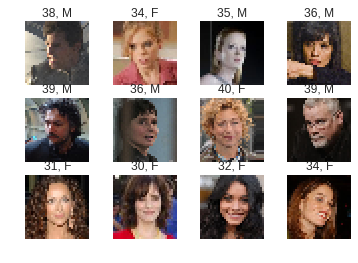

In [26]:

cols, rows = 4, 3
img_num = cols * rows
path_root = "data/{}_crop/".format(db)
img_ids = np.random.choice(len(test_ages), img_num)
sub_test_images = test_images[img_ids,:,:,:]

# predict
results = model.predict(sub_test_images)
predicted_genders = results[0]
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(sub_test_images[i,:,:,:], cv2.COLOR_BGR2RGB))
    plt.title("{}, {}".format(int(predicted_ages[i]),
                              "F" if predicted_genders[i][0]>0.5 else "M"))
    plt.axis('off')
plt.savefig("result.png")